In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
all_files = os.listdir('./out')
ols_results = ['./out/' + f for f in all_files if f.endswith('ols.txt')]
grid_results = ['./out/' +f for f in all_files if f.endswith('grid.csv')]
metr_results = ['./out/' +f for f in all_files if f.endswith('met.csv')]

In [3]:
df = pd.read_csv(metr_results[0])

In [4]:
metr_results[0]

'./out/se_2-su_5-rho_-0.4-lam_-0.4-met.csv'

In [5]:
df[[col for col in df.columns if not col.startswith('Thetas')]].head()

,Lambda,Rho,Betas_0,Betas_1,Betas_2,Betas_3,Betas_4,Sigma2_e,Sigma2_u,method
0,0.500000,0.272376,3.682748,-2.112028,4.084815,-6.367432,8.462914,1273.241937,139.453774,met
1,0.471522,0.272376,4.061630,-1.981051,4.253220,-6.158003,8.166098,846.685053,153.426270,met
2,0.471522,0.272376,5.764061,-2.027988,4.259300,-6.031979,8.325618,970.334278,123.931990,met
3,0.471522,0.272376,5.365923,-2.104932,3.888475,-6.327482,8.257415,894.554846,102.301903,met
4,0.471522,0.272376,7.808820,-2.187547,4.287728,-6.151371,8.333908,813.497491,88.743695,met


In [6]:
of_interest = ['Rho', 'Lambda', *['Betas_{}'.format(i) for i in range(5)]]

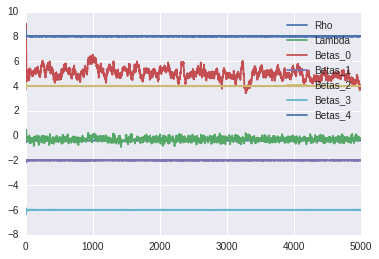

In [7]:
df[of_interest].plot()

In [8]:
def parse_filename(filepath):
    true_vals = filepath
    rho_neg = true_vals.split('rho_')[-1][0] == '-'
    lam_neg = true_vals.split('lam_')[-1][0] == '-'
    true_vals = true_vals.replace('_-', '_')
    true_vals = true_vals.replace('_' ,'__')
    true_vals = true_vals.split('/')[-1]
    true_vals = '.'.join(true_vals.split('.')[:-1])
    
    true_vals = true_vals.split('-')
    true_vals = [x.split('__') for x in true_vals]
    se, su, rho, lam = [x[1] for x in true_vals[:-1]]
    true_vals = {k:None for k in of_interest}
    true_vals['Rho'] = float(rho) * (-1 * (2*rho_neg-1))
    true_vals['Lambda'] = float(lam) * (-1 * (2*lam_neg-1)) #if it's negative, keep it that way
    true_vals['Sigma2_u'] = su
    true_vals['Sigma2_e'] = se
    true_vals.update({k:v for k,v in zip(['Betas_{}'.format(i) for i in range(5)], 
                                         [4] + [(-1)**(i%2) * 2*i for i in range(1,5)])})
    return true_vals

In [13]:
def plot_results(filepath, cutoff=100, **kw):
    df = pd.read_csv(filepath)
    
    ##parse filename for true values
    true_vals = parse_filename(filepath)
    
    n_plots = len(true_vals)
    fig, ax = plt.subplots(n_plots, 2, **kw)
    
    for i, key in enumerate(sorted(true_vals.keys())):
        real = true_vals[key]
        sns.distplot(df[key].values[cutoff:], vertical=True, ax=ax[i, 1])
        ax[i,0].plot(df[key].values[cutoff:])
        
        meanval = df[key].values[cutoff:].mean()
        ax[i,0].hlines(meanval,xmin=0, xmax=df[key].values.shape[0]-cutoff, color='r')
        ax[i,1].hlines(meanval,xmin=0, xmax=1, color='r')
        ax[i,0].set_title(key)
        ax[i,1].set_title('True Value: {}'.format(real))


    return fig, ax

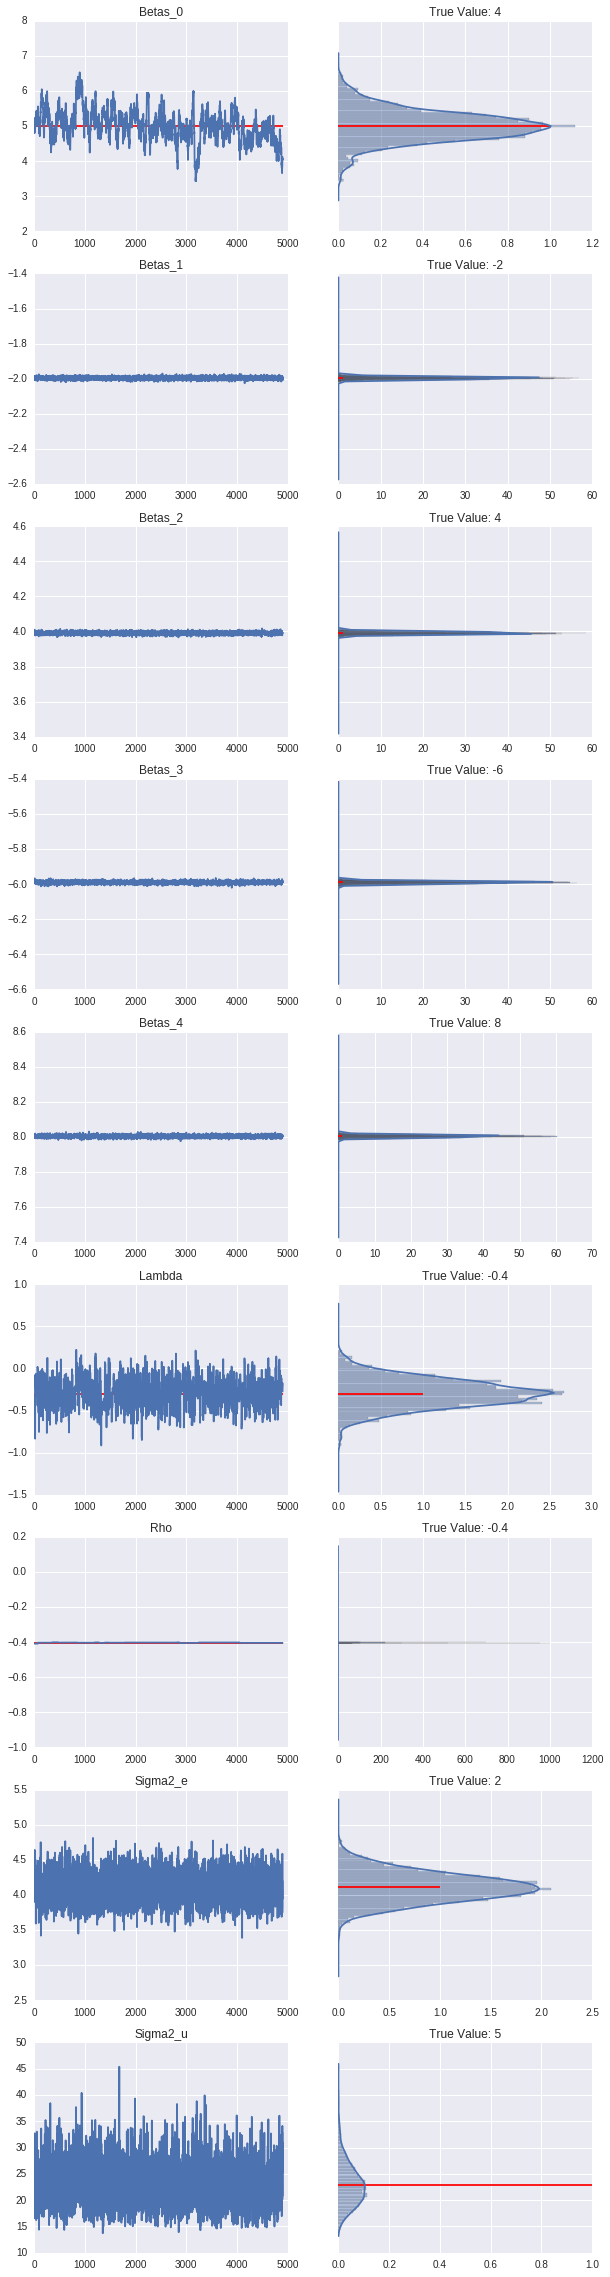

In [14]:
plot_results(metr_results[0], figsize=(10,40), sharey='row')
plt.savefig(os.path.splitext(metr_results[0])[0] + '.png')
plt.show()

In [15]:
metr_results[0]

'./out/se_2-su_5-rho_-0.4-lam_-0.4-met.csv'

In [16]:
grid_results[0]

'./out/se_2-su_5-rho_-0.4-lam_-0.4-grid.csv'

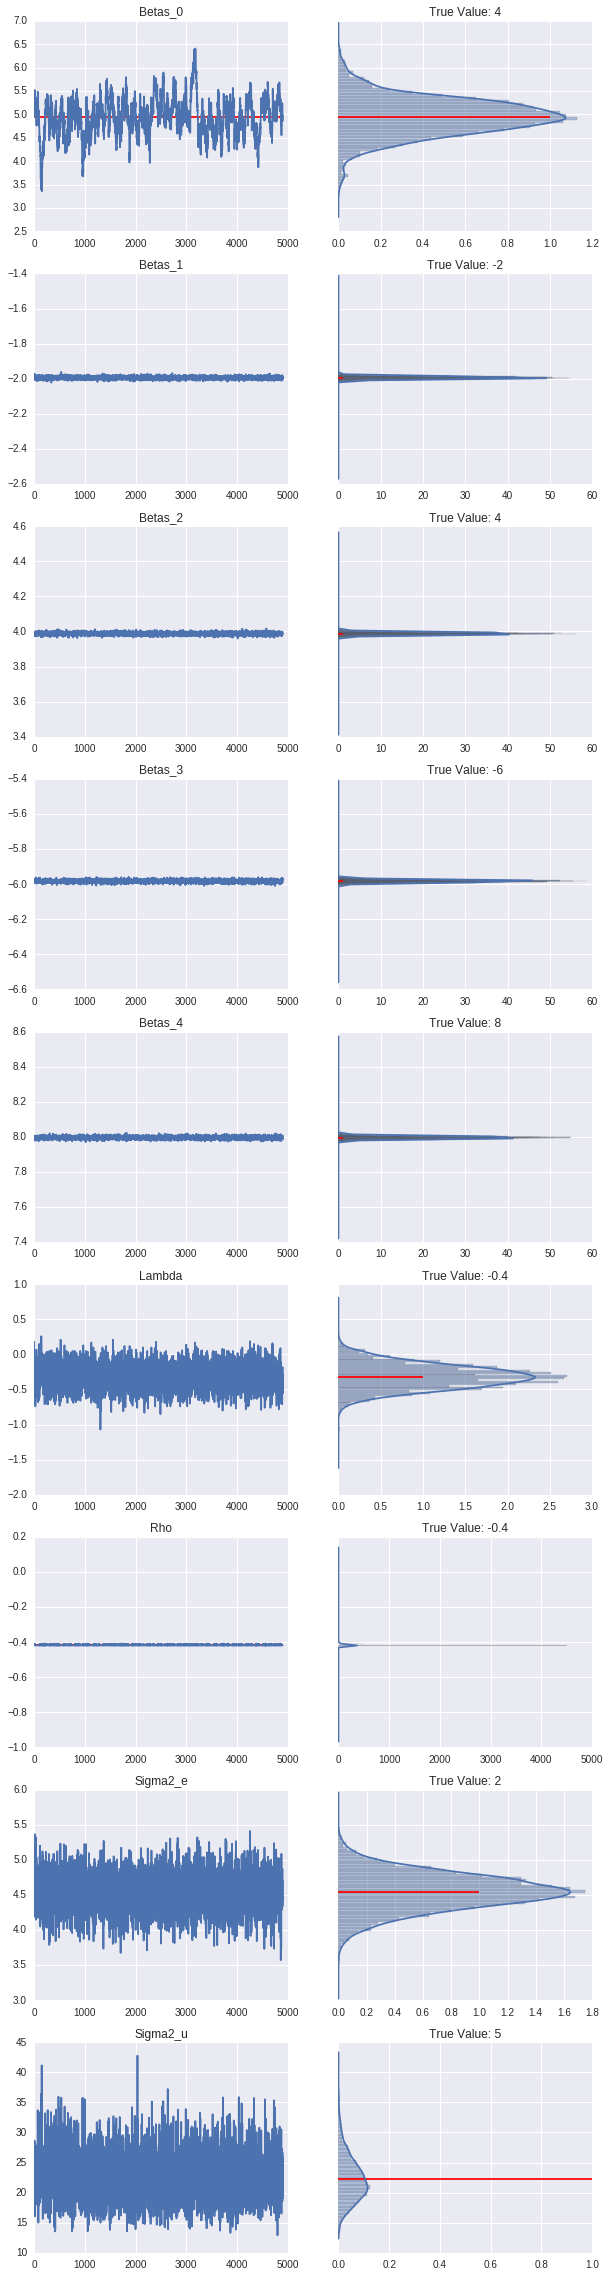

In [17]:
plot_results(grid_results[0], figsize=(10,40), sharey='row')
plt.savefig(os.path.splitext(metr_results[0])[0] + '.png')
plt.show()

In [53]:
def plot_facet(Rho=True, Lambda=True, Sigma2_e=2, method='grid', ax=None):
    rhovals = [-.8,-.4,0,.4,.8]
    lamvals = [-.8,-.4,0,.4,.8]
    sig2evals = [.2, 2, 20]
    if Rho and Lambda:
        if Rho >= Lambda:
            cols = 'Rho', rhovals
            rows = 'Lambda', lamvals
        else:
            rows = 'Rho', rhovals
            cols = 'Lambda', lamvals
    
    files = ['./out/' + f for f in os.listdir('./out/') if f.endswith(method + '.csv')]
    
    if ax is None:
        fig, ax = plt.subplots(nrows=len(rows[1]), ncols=len(cols[1]), figsize=(15,15))
        stacked=False
    else:
        stacked=True
    for f in files:
        pdict = parse_filename(f)
        if float(pdict['Sigma2_e']) != Sigma2_e:
            continue
        df = pd.read_csv(f)
        rowdata = df[rows[0]].values[100:]
        coldata = df[cols[0]].values[100:]
        ridx = rows[1].index(pdict[rows[0]])
        cidx = cols[1].index(pdict[cols[0]])
        ax[ridx, cidx].hist(coldata, bins=10, stacked=stacked)
        ax[ridx, cidx].set_xticklabels([])
        ax[ridx, cidx].set_yticklabels([])
        ax[ridx, cidx].set_title("$\\{}={} | \\{}={}$".format(cols[0].lower(), pdict[cols[0]],
                                                             rows[0].lower(), pdict[rows[0]]))
        ax[ridx, cidx].set_xlim(-1,1)
    return ax

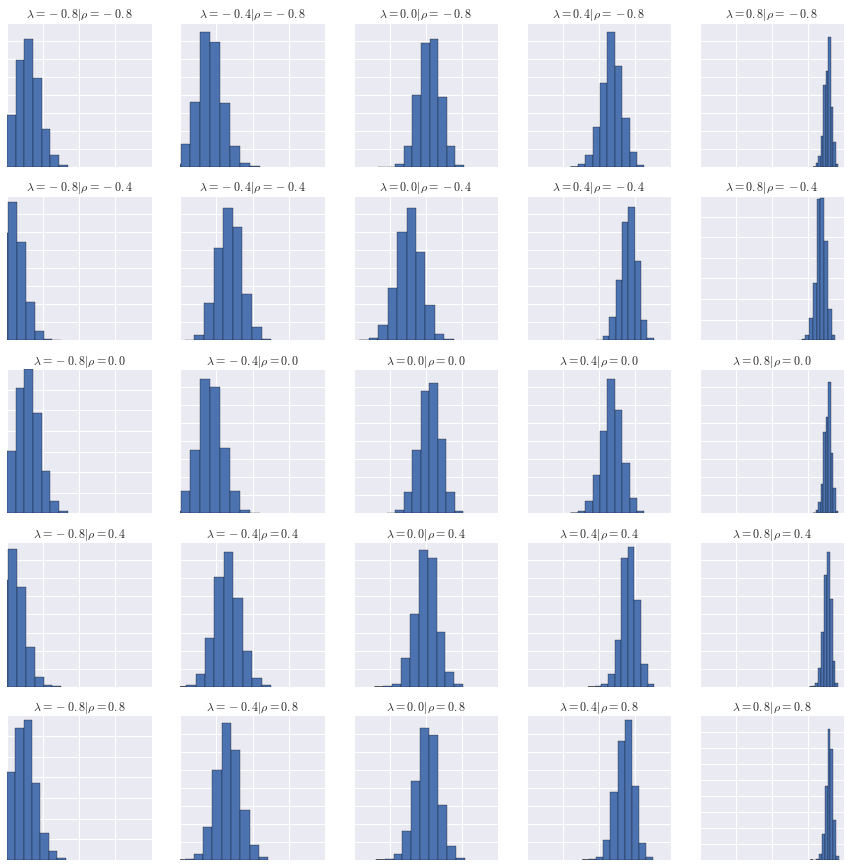

In [54]:
a = plot_facet(Lambda=2)
#plot_facet(ax=a)
plt.savefig('spatials_grid_sig2e-2.png')
plt.show()

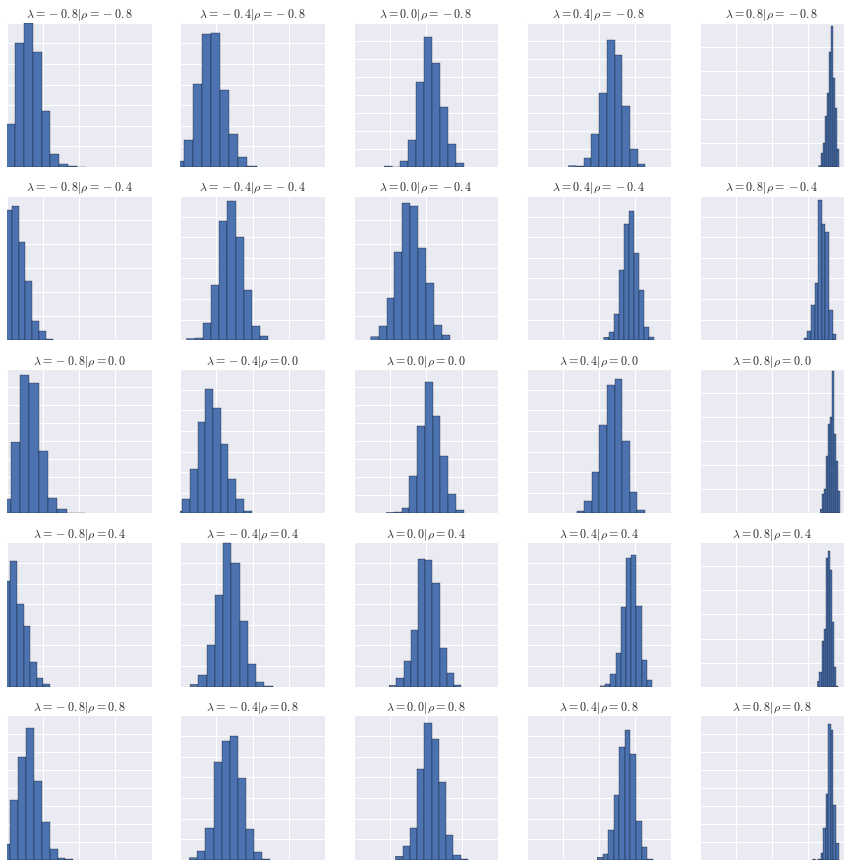

In [55]:
a = plot_facet(Lambda=2, method='met')
#plot_facet(ax=a, method='met')
plt.savefig('spatials_met_sig2e-2.png')
plt.show()

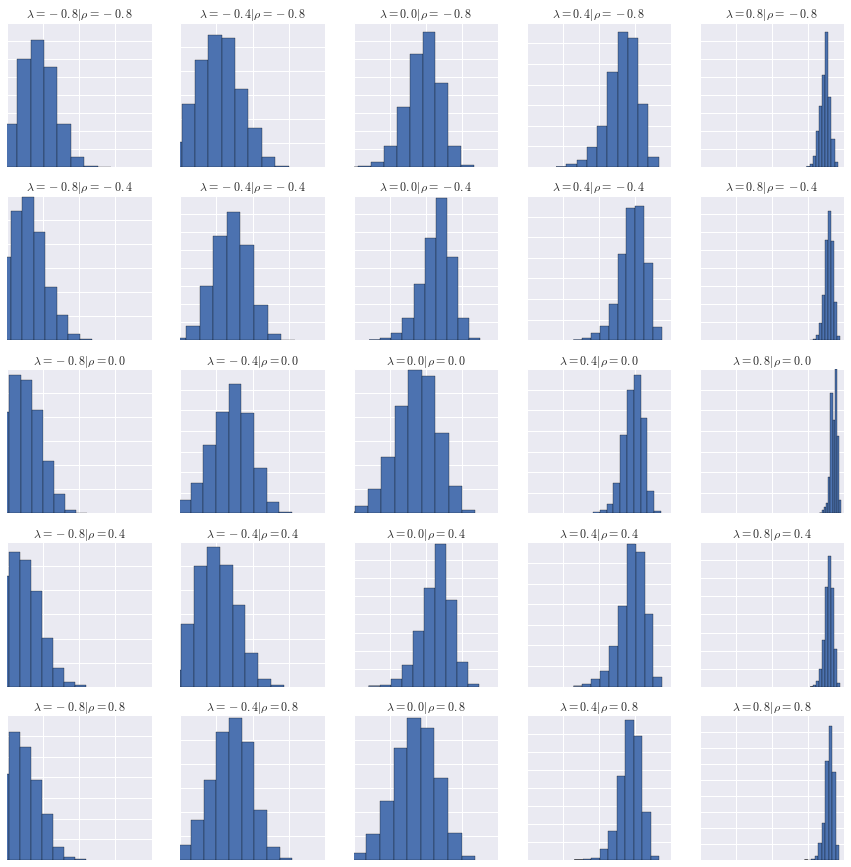

In [56]:
a = plot_facet(Lambda=2, Sigma2_e = 10)
#plot_facet(ax=a, Sigma2_e = 10)
plt.savefig('spatials_grid_sig2e-10.png')
plt.show()

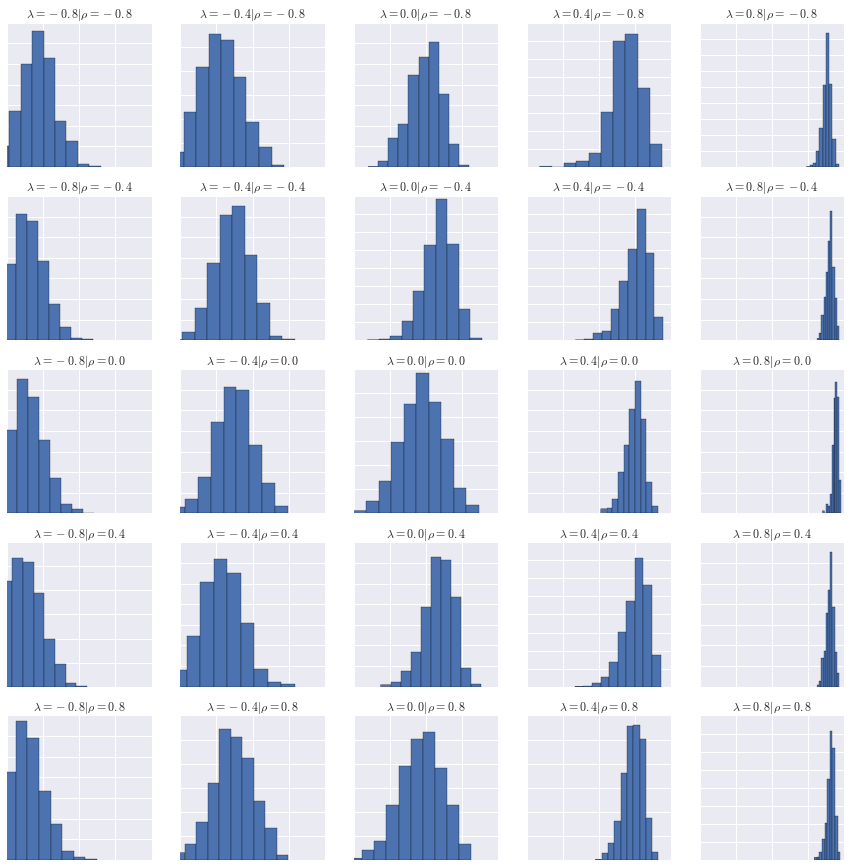

In [57]:
a = plot_facet(Lambda=2, Sigma2_e = 10, method='met')
#plot_facet(ax=a, Sigma2_e = 10, method='met')
plt.savefig('spatials_met_sig2e-10.png')
plt.show()